# Experimento para detección semi-automática de recorridos, tomando agrupando por idsam + fecha

La idea es que utilizando el patrón dibujado por cada idsam dentro de un día se pueda detectar y agrupar los patrones de recorridos iguales/similares a manera de poder detectar la linea/ramal pudiendo ignorar el idrutaestacion.

Esto nos permitiria:

a. Auto-detectar el ramal por su trayectoria y poder empezar a limpiar el idrutaestacion 0000

b. Detectar alteraciones y anormalidades en el trayecto esperado.

c. Predecir congestión? Acá ya volando alto, pero el markdown perdona todo.

Importar la librerías que vamos a necesitar. Como vamos a verificar mucho del funcionamiento manualmente para poder desarrollar una metodologia, vamos a hacer varios mapas.

In [108]:
import pandas as pd
import numpy as np

import os
import datetime

import geopandas as gpd
import contextily as cx

import matplotlib.pyplot as plt

Carguemos los datos de una linea de prueba, para este caso vamos a usar la idrutaestacion __0145__ que esta asociada a __"ITA - LAMBARÉ (Canal 13) Troncal 1"__ de la empresa **"3 DE FEBRERO SA"**

In [109]:
datos_rutas = pd.read_csv("../../data/interim/datosporlinea/linea-0145.csv", sep = ';',low_memory=False)
print(datos_rutas.sample(10))

                            serialtarjeta           idsam   
343068   3e60222e63763685707f8412eda8f31a  04121b1aaa6380  \
880658   ef3f09aa9d3ed17f213c224d431d21d1  041c20e24e6180   
891705   b2985f94d5de80d6fa84900aacc75da4  04301222b95a80   
1038023  ed10ae0cac5867d4973379b268706b89  04301222b95a80   
143087   87e3e58c954d40265989df7d3d9d4ed8  04081b1a846280   
961658   04a2e8b98a19c5c0385fb097d0c3f57f  041c1ce24e6180   
622419   ed33cf1276e963c4dbcc0ec0bfae3bee  0408151a846280   
621778   a6b898bd03e292846e30afbb652af0e7  04301622b95a80   
412965   76a76469c9b7b52a3b118455d9eee849  041c1fe24e6180   
867194   5775fbebf5d1ba5967a25a1075e074b7  04300e22b95a80   

                       fechahoraevento producto  montoevento   
343068   2022/12/06 19:07:48.000000000       MO         2300  \
880658   2022/07/13 16:44:12.000000000       MO         2300   
891705   2022/07/08 13:38:38.000000000       MO         3400   
1038023  2022/09/14 19:18:30.000000000       MO         3400   
143087  

Ahora empezamos a limpiar todos los datos que no nos interesan.

In [110]:
print(datos_rutas.columns.values.tolist())

['serialtarjeta', 'idsam', 'fechahoraevento', 'producto', 'montoevento', 'consecutivoevento', 'identidad', 'tipoevento', 'latitude', 'longitude', 'idrutaestacion', 'tipotransporte']


In [111]:
datos_rutas.drop(['serialtarjeta', 'producto', 'montoevento', 'consecutivoevento', 'identidad', 'tipoevento', 'tipotransporte'],inplace=True, axis=1)
print(datos_rutas.sample(10))

                 idsam                fechahoraevento  latitude  longitude   
725866  041c1de24e6180  2022/05/16 16:44:14.000000000 -25.31239  -57.58626  \
1419    041c1ce24e6180  2022/01/29 20:34:34.000000000 -25.41860  -57.45552   
236929  04301722b95a80  2022/11/18 08:42:32.000000000 -25.36966  -57.47993   
467053  04132f1aaa6380  2023/02/10 11:20:12.000000000 -25.34587  -57.50615   
745866  04300e22b95a80  2022/05/07 16:38:08.000000000 -25.31638  -57.57459   
324053  04131122626c80  2022/12/15 04:19:26.000000000 -25.40034  -57.46471   
13351   0408151a846280  2022/01/24 14:14:14.000000000 -25.22254  -57.53257   
539191  04120e1aaa6380  2023/03/12 05:36:52.000000000 -25.29051  -57.45272   
652121  041a38e24e6180  2022/04/22 18:12:00.000000000 -25.44717  -57.43838   
296722  04082c1a846280  2022/12/26 07:30:30.000000000 -25.50625  -57.36447   

        idrutaestacion  
725866             145  
1419               145  
236929             145  
467053             145  
745866          

Ahora que solamente tenemos los identificadores de los lectores (buses), los momentos en que ocurren los eventos, la posición geografica del evento (latitude,longitude) y el identificador de la ruta; ya podemos empezar a trabajar.

In [112]:
datos_rutas.info()
datos_rutas.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1074281 entries, 0 to 1074280
Data columns (total 5 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   idsam            1074281 non-null  object 
 1   fechahoraevento  1074281 non-null  object 
 2   latitude         1074281 non-null  float64
 3   longitude        1074281 non-null  float64
 4   idrutaestacion   1074281 non-null  int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 41.0+ MB


,idsam,fechahoraevento,latitude,longitude,idrutaestacion
197210,041c1de24e6180,2022/10/03 15:24:50.000000000,-25.44722,-57.43830,145
254473,04132f1aaa6380,2022/11/11 12:35:56.000000000,-25.51113,-57.36286,145
361506,04121b1aaa6380,2023/01/28 18:36:22.000000000,-25.32461,-57.55232,145
484279,0410221aaa6380,2023/02/03 13:49:10.000000000,-25.34577,-57.50578,145
921922,041c1fe24e6180,2022/08/27 12:56:18.000000000,-25.31234,-57.58626,145
86677,04301622b95a80,2022/02/15 05:04:26.000000000,-25.41915,-57.45524,145
405095,0408181a846280,2023/01/11 22:10:58.000000000,-25.33407,-57.53683,145
212488,04081b1a846280,2022/11/26 12:15:00.000000000,-25.32595,-57.54962,145
718227,041918e24e6180,2022/05/19 07:10:14.000000000,-25.20483,-57.52529,145
108172,04081b1a846280,2022/02/06 18:32:30.000000000,-25.50708,-57.35780,145


Primeramente revisamos los datos y hacemos algo de limpieza y ajustes.

In [113]:
# Convertimos la columna de cadena a fecha
datos_rutas['fechahoraevento']= pd.to_datetime(datos_rutas['fechahoraevento'])

# Remover todos los casos donde latitud y longitud sean ceros
datos_rutas = datos_rutas[(datos_rutas[['latitude','longitude']] != 0).all(axis=1)] 
# datos_rutas["fechastr"] = datos_rutas['fechahoraevento'].dt.strftime('%Y%m%d%H%M')
datos_rutas["fechastr"] = datos_rutas['fechahoraevento'].dt.strftime('%Y%m%d')
# REDUCIMOS LA RESOLUCION DE LOS DATOS GPS A 4 DECIMALES PARA FACILITAR LA AGRUPACION Y GENERACION DE TRAYECTORIAS
datos_rutas["latitude"]=datos_rutas["latitude"] * 1.000000000001
datos_rutas["longitude"]=datos_rutas["longitude"] * 1.000000000001

# datos_rutas.loc[:, "latitude"] = datos_rutas["latitude"].map('{:.4f}'.format)
# datos_rutas.loc[:, "longitude"] = datos_rutas["longitude"].map('{:.4f}'.format)

# datos_rutas["latitude"]=datos_rutas["latitude"].round(4) 
# datos_rutas["longitude"]=datos_rutas["longitude"].round(4)
datos_rutas

,idsam,fechahoraevento,latitude,longitude,idrutaestacion,fechastr
0,041d12e24e6180,2022-01-30 23:49:56,-25.38953,-57.47013,145,20220130
1,041d12e24e6180,2022-01-30 23:40:46,-25.34554,-57.50541,145,20220130
2,041d12e24e6180,2022-01-30 23:40:40,-25.34554,-57.50541,145,20220130
3,041d12e24e6180,2022-01-30 23:40:34,-25.34554,-57.50541,145,20220130
4,041d12e24e6180,2022-01-30 23:40:30,-25.34554,-57.50541,145,20220130
...,...,...,...,...,...,...
1074276,04132822626c80,2022-09-01 05:22:52,-25.34199,-57.62491,145,20220901
1074277,04132822626c80,2022-09-01 05:22:22,-25.34224,-57.62633,145,20220901
1074278,04132822626c80,2022-09-01 05:20:38,-25.34265,-57.63326,145,20220901
1074279,04132822626c80,2022-09-01 05:20:38,-25.34265,-57.63326,145,20220901


Ahora vamos a tomar un idsam en particular y vamos a comenzar el trabajo de intentar crear una ruta estandar contra la cual vamos a comprar a las demas.

In [114]:
# Creamos un listado de todos los idsams (lectores-vehiculos) presentes en el dataset limpio
idsams = datos_rutas['idsam'].unique() 
print(idsams.shape)
print(idsams)
fechas_trayectorias = datos_rutas['fechastr'].unique() 
print(fechas_trayectorias.shape)
print(fechas_trayectorias)

(45,)
['041d12e24e6180' '04132822626c80' '04300e22b95a80' '0408191a846280'
 '04081b1a846280' '041922e24e6180' '04132f1aaa6380' '0408181a846280'
 '041c24e24e6180' '0408131a846280' '04191be24e6180' '041a38e24e6180'
 '041c21e24e6180' '04301222b95a80' '041c1ce24e6180' '041d14e24e6180'
 '041c20e24e6180' '04301522b95a80' '0408211a846280' '0413271aaa6380'
 '04081f1a846280' '0408171a846280' '0408201a846280' '04191fe24e6180'
 '041d0fe24e6180' '04081e1a846280' '04301722b95a80' '04082c1a846280'
 '0411171aaa6380' '04301622b95a80' '0408151a846280' '0409131a846280'
 '041917e24e6180' '041c1fe24e6180' '041c22e24e6180' '041c1de24e6180'
 '041918e24e6180' '04121b1aaa6380' '04131122626c80' '04301a22b95a80'
 '04303e22b95a80' '04120e1aaa6380' '0410221aaa6380' '04203ed2955d80'
 '04102e1aaa6380']
(440,)
['20220130' '20220129' '20220128' '20220127' '20220126' '20220125'
 '20220124' '20220123' '20220122' '20220121' '20220120' '20220119'
 '20220118' '20220117' '20220116' '20220115' '20220114' '20220113'
 '202201

In [115]:
# Tomar todos los datos para un idsam en particular
vehiculo_test = datos_rutas

# Asegurarnos que todos los valores estan ordenados por fecha
vehiculo_test = vehiculo_test.sort_values(by='fechahoraevento')

# Tomar solo muestras de un periodo en particular
dia = vehiculo_test[(vehiculo_test['fechahoraevento'] > "2021-12-31") & (vehiculo_test['fechahoraevento'] < "2023-01-01")]
minx, miny, maxx, maxy = gpd.GeoDataFrame(dia, geometry=gpd.points_from_xy(dia.longitude,dia.latitude),crs="EPSG:4326").total_bounds

print("Esquinas de la ruta para 0145: ",minx, miny, maxx, maxy)

Esquinas de la ruta para 0145:  -57.63565000005764 -25.520470000025522 -57.35287000005736 -25.168420000025172


Ahora tratemos de visualizar que paso por día con esos lectores

In [116]:
fechasstr = datos_rutas['fechastr'].unique()
DIAS = ['Domingo','Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado']

for fechastr in fechasstr:
    continue
    imgpath = './graphs/'+fechastr+'.png'
    
    if(os.path.isfile(imgpath)):
        continue
    
    # print(imgpath)
    
    dia_test = dia[(dia[['fechastr']] == fechastr).all(axis=1)] 

    fecha_linda = fechastr[:4]+'-'+fechastr[4:6]+'-'+fechastr[6:8]
    fecha_linda = fecha_linda + " " + DIAS[int(datetime.datetime.strptime(fechastr, '%Y%m%d').strftime("%w"))]
    
    latlon_dia = gpd.GeoDataFrame(dia_test, geometry=gpd.points_from_xy(dia_test.longitude,dia_test.latitude),crs="EPSG:4326")
    try:
        mapa_dia_plot = latlon_dia.plot(figsize=(9, 9),legend=False,marker='+',markersize=20, column='idsam')
        mapa_dia_plot.set(title='Datos '+fecha_linda+' para el idrutaestacion 0145')
        cx.add_basemap(mapa_dia_plot, crs="EPSG:4326",source=cx.providers.Stamen.Toner)
        mapa_dia_plot.set_xlim(xmin=minx, xmax=maxx)
        mapa_dia_plot.set_ylim(ymin=miny, ymax=maxy)
        plt.axis('equal')
        plt.savefig(imgpath,dpi=300)
        plt.close()
    except:
        continue
 

# print("Graficos generados")

Ver animación de los gráficos [aquí](https://imgur.com/a/GPNwaNv)

Cada mapa por fecha individual se encuentra en la carpeta [/graphs/](https://github.com/pabloacastillo/billetaje-electronico-py-2022/tree/main/notebooks/recorridos-por-idsam-idrutalinea/graphs)

Ahora que tenemos cierta idea de cual es el moviento de cada lector, podemos comenzar a crear conjeturas de como podemos generar una trayectoria.

- Uno de los aprendizajes que nos dejan estas imagenes es que un lector no necesariamente esta unido a una sola ruta; un lector puede, durante el día o durante la semana, cambiar de ruta.

- Una misma linea cubre rutas diferentes; pero estas otras rutas son cubiertas con frecuencias diferentes. Casi puede notarse una trayectoria principal y otra secundaria(s); cuando el lector debe cubrir una ruta adicional.

- Las rectas que vamos a dibujar deberan ser por día y por idsam; y rectas que no se ajusten a lo normal deberan ser agrupadas aparte o descartadas. Esto puede generar posiblemente que un idrutaestacion genere como minimo una cantidad de rutas asignadas + 1


Como notas valiosas sobre las cuales vamos a trabajar ahora dejo dos links:
- [Exploring Trip Fuel Consumption by Machine Learning from GPS and CAN Bus Data](https://doi.org/10.11175/easts.11.906)
- [Nivel de exactitud (Accuracy) que agrega cada digito de un valor GPS](https://gis.stackexchange.com/questions/8650/measuring-accuracy-of-latitude-and-longitude)

In [117]:
vehiculo_random = datos_rutas.sample(1).values[0]
# print(vehiculo_random)
# vehiculo_random = ['0408211a846280',('2022-02-16 04:47:48'), -25.5071, -57.3592, 145,'20220216']
vehiculo_test = datos_rutas[(datos_rutas[['idsam']] == vehiculo_random[0]).all(axis=1)] 
vehiculo_test = vehiculo_test[(vehiculo_test[['fechastr']] == vehiculo_random[5]).all(axis=1)] 
vehiculo_test = vehiculo_test.sort_values(by='fechahoraevento')
vehiculo_test

,idsam,fechahoraevento,latitude,longitude,idrutaestacion,fechastr
470206,04191be24e6180,2023-02-09 05:37:36,-25.44926,-57.36900,145,20230209
470205,04191be24e6180,2023-02-09 05:37:42,-25.44937,-57.36899,145,20230209
470203,04191be24e6180,2023-02-09 05:38:38,-25.45114,-57.36859,145,20230209
470202,04191be24e6180,2023-02-09 05:40:20,-25.46006,-57.36659,145,20230209
470201,04191be24e6180,2023-02-09 05:41:52,-25.46616,-57.36520,145,20230209
...,...,...,...,...,...,...
468557,04191be24e6180,2023-02-09 18:00:14,-25.44941,-57.36898,145,20230209
468556,04191be24e6180,2023-02-09 18:00:24,-25.44941,-57.36898,145,20230209
468554,04191be24e6180,2023-02-09 18:00:46,-25.44971,-57.36893,145,20230209
468545,04191be24e6180,2023-02-09 18:04:42,-25.46749,-57.36486,145,20230209


Ahora vamos a agregar la librerias con las que vamos a empezar a dibujar los trayectos por día por idsam

In [118]:
import osmnx as ox
import networkx as nx

ox.settings.log_console=True
ox.settings.use_cache=True

mode = 'drive' # 'drive', 'bike', 'walk'
optimizer = 'time' # length
place = 'Asuncion, Paraguay'
graph = ox.graph_from_place(place, network_type = mode)
print(graph)



# vehiculo_ejemplo = vehiculo_test.head(5)
vehiculo_ejemplo = vehiculo_test
_anterior = vehiculo_ejemplo.iloc[0]
start_latlng = (_anterior.latitude,_anterior.longitude)

vehiculo_ejemplo = vehiculo_ejemplo.iloc[1: , :]
shortest_route_map_flag = False

# DETECCION DE INICIO Y FIN DE BUCLE DE TRAYECTO
# Tiempos entre pasajeros-rutas 
deltat_avg = 0
deltat_min = 0
deltat_max = 0

for indice, punto in vehiculo_ejemplo.iterrows():
    
    diff_t=punto.fechahoraevento.timestamp() - _anterior.fechahoraevento.timestamp()
    deltat_avg+=diff_t
        
    if(diff_t>deltat_max): deltat_max=diff_t
    if(deltat_min>diff_t or deltat_min==0): deltat_min=diff_t

    
    end_latlng = (punto.latitude , punto.longitude)
    
    orig_node = ox.distance.nearest_nodes(graph, start_latlng[1], start_latlng[0])
    dest_node = ox.distance.nearest_nodes(graph, end_latlng[1], end_latlng[0])
    
    shortest_route = nx.shortest_path(graph,orig_node, dest_node, weight=optimizer)
    if(len(shortest_route)<2):
        continue
        
    if(shortest_route_map_flag==False):
        shortest_route_map = ox.plot_route_folium(graph, shortest_route, tiles='openstreetmap')
        shortest_route_map_flag=True
    else:
        shortest_route_map = ox.plot_route_folium(graph, shortest_route,route_map=shortest_route_map, tiles='openstreetmap')


    start_latlng = (punto.latitude , punto.longitude)
    _anterior=punto
    # if(diff_t>5000): break
    
deltat_avg=round(deltat_avg/(len(vehiculo_ejemplo. index)),2)
print("deltat_avg",deltat_avg,'deltat_min',deltat_min,"deltat_max",deltat_max)
shortest_route_map

MultiDiGraph with 9823 nodes and 26355 edges
deltat_avg 387.88 deltat_min 4.0 deltat_max 9956.0


Vemos que la diferencia maxima de tiempo que el vehiculo esta sin levantar pasajeros es de 9956 segundos, o 2 horas y 45 minutos.
Esto nos puede dar una forma de detectar:

- El punto de inicio de la ruta
- El punto de fin de la ruta
- Cual es el tiempo de entre pasajeros
- Cual es el tiempo de recorrido total de un bucle
- Cuanto tiempo esta el bus parado descansando

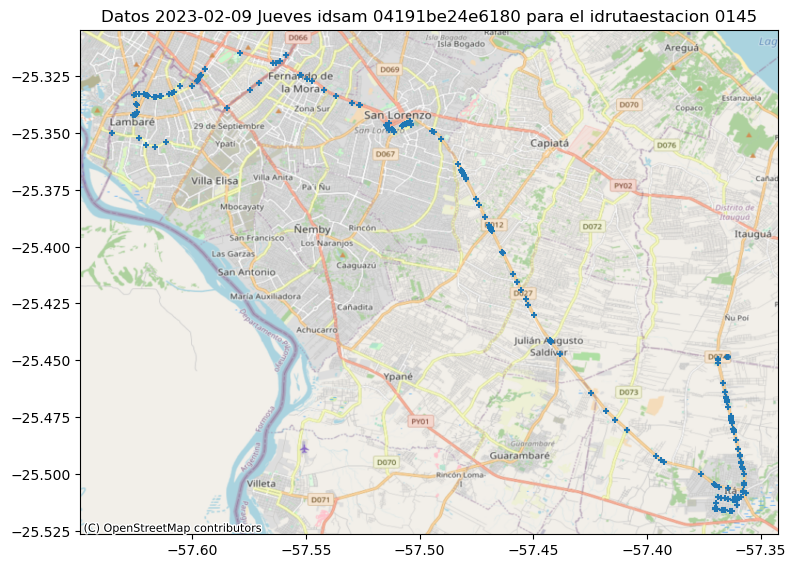

In [119]:
rand_idsam = vehiculo_ejemplo['idsam'].iloc[0]
fechastr = vehiculo_ejemplo['fechastr'].iloc[0]
fecha_linda = fechastr[:4]+'-'+fechastr[4:6]+'-'+fechastr[6:8]
fecha_linda = fecha_linda + " " + DIAS[int(datetime.datetime.strptime(fechastr, '%Y%m%d').strftime("%w"))]

latlon_dia = gpd.GeoDataFrame(vehiculo_ejemplo, geometry=gpd.points_from_xy(vehiculo_ejemplo.longitude,vehiculo_ejemplo.latitude),crs="EPSG:4326")

mapa_dia_plot = latlon_dia.plot(figsize=(9, 9),legend=False,marker='+',markersize=20)
mapa_dia_plot.set(title='Datos '+fecha_linda+' idsam '+rand_idsam+' para el idrutaestacion 0145')
cx.add_basemap(mapa_dia_plot, crs="EPSG:4326",source=cx.providers.OpenStreetMap.Mapnik)